# This notebook shows ClusterBuster and Homer experiments.
#### It uses contribution scores and TFModisco scores generated in the FLY_EFS_TFModisco notebook.
#### The motif database file is provided in ./data/tomtom folder
#### It consists of:
* Getting TFModisco patterns and saving as txt file to be later used by ClusterBuster.
* Running Tomtom on TFModisco patterns.
* Running ClusterBuster by using TFModisco pattern PWMs on the sequences generated by in silico evolution, motif implantation, and GAN.
* Running Homer using Random and Evolved sequences as foreground and background sequences, and vice versa.
#### ClusterBuster results are in ./data/cbust folder.
#### Homer results are in ./data/homer folder.
#### Figures are saved to ./figures/cbust folder

### General imports


In [1]:
import sys  
import os
import pickle
import utils
import numpy as np
import scipy
import pandas as pd
import tensorflow as tf
tf.disable_eager_execution()
tf.logging.set_verbosity(tf.logging.ERROR)

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
matplotlib.style.use("default")
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

nuc_to_onehot = {"A":[1, 0, 0, 0],"C":[0, 1, 0, 0],"G":[0, 0, 1, 0],"T":[0, 0, 0, 1]}

### Loading the contribution scores calculated in the FLY_EFS_TFModisco script

In [3]:
tasks = {}
task_to_scores = {}
task_to_hyp_scores = {}
onehot_data = {}
for i in [1]:
    f = open("./data/tfmodisco/KCEFS_M"+str(i)+"_topic35_shapvalues.pkl", "rb")
    tasks[i] = pickle.load(f)
    task_to_scores[i] = pickle.load(f)
    task_to_hyp_scores[i] = pickle.load(f)
    onehot_data[i] = pickle.load(f)
    f.close()

### Loading the TFModisco results calculated in the MM_EFS_TFModisco script
### Trimming the identified patterns and saving them as text and =.cb files to be used by ClusterBuster and TOMTOM

In [4]:
# From TFModisco
# def get_ic_trimming_indices(ppm, background, threshold, pseudocount=0.001):
#     """Return tuple of indices to trim to if ppm is trimmed by info content.
#     The ppm will be trimmed from the left and from the right until a position
#      that meets the information content specified by threshold is found. A
#      base of 2 is used for the infromation content.
#     Arguments:
#         threshold: the minimum information content.
#         remaining arguments same as for compute_per_position_ic
#     Returns:
#         (start_idx, end_idx). start_idx is inclusive, end_idx is exclusive.
#     """
#     per_position_ic = compute_per_position_ic(
#                        ppm=ppm, background=background, pseudocount=pseudocount)
#     passing_positions = np.where(per_position_ic >= threshold)
#     return (passing_positions[0][0], passing_positions[0][-1]+1)

# def compute_per_position_ic(ppm, background, pseudocount):
#     """Compute information content at each position of ppm.
#     Arguments:
#         ppm: should have dimensions of length x alphabet. Entries along the
#             alphabet axis should sum to 1.
#         background: the background base frequencies
#         pseudocount: pseudocount to be added to the probabilities of the ppm
#             to prevent overflow/underflow.
#     Returns:
#         total information content at each positon of the ppm.
#     """
#     assert len(ppm.shape)==2
#     assert ppm.shape[1]==len(background),\
#             "Make sure the letter axis is the second axis"
#     assert (np.max(np.abs(np.sum(ppm, axis=1)-1.0)) < 1e-7),(
#              "Probabilities don't sum to 1 along axis 1 in "
#              +str(ppm)+"\n"+str(np.sum(ppm, axis=1)))
#     alphabet_len = len(background)
#     ic = ((np.log((ppm+pseudocount)/(1 + pseudocount*alphabet_len))/np.log(2))
#           *ppm - (np.log(background)*background/np.log(2))[None,:])
#     return np.sum(ic,axis=1)

# import h5py
# n_mut = 1
# hdf5_results = h5py.File("data/tfmodisco/KCEFS_M1_results.hdf5","r")

# metacluster_names = [x.decode("utf-8") for x in list(hdf5_results["metaclustering_results"]["all_metacluster_names"][:])]

# motif_dict = {}
# with open("data/tfmodisco/selected_patterns.txt", 'w') as fw_pattern:
#     for metacluster_name in metacluster_names:
#         motif_dict[metacluster_name] = {}
#         metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"][metacluster_name])
#         pattern_names = [x.decode("utf-8") for x in list(metacluster_grp["seqlets_to_patterns_result"]["patterns"]["all_pattern_names"][:])]

#         background = np.mean(onehot_data[n_mut], axis=(0,1))
#         for pattern_name in pattern_names:
#             pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
#             pattern_array = np.array(pattern["sequence"]["fwd"])
#             start, end = get_ic_trimming_indices(pattern_array, background=np.mean(onehot_data[n_mut], axis=(0,1)), threshold=0.1)
#             # Motif(pattern_array).plot_logo()
#             # Motif(pattern_array[start:end,:]).plot_logo()
#             #motif_dict[metacluster_name][pattern_name] = Motif(np.array(pattern["sequence"]["fwd"])).trim(0.1)
            
#             print(f'{metacluster_name}_{pattern_name}',file=fw_pattern)

#             with open(f'data/cbust/EFS_M1_motifs/MMFS_M{n_mut}_{metacluster_name}_{pattern_name}.cb', 'w') as fw:
#                 print(f'>{metacluster_name}_{pattern_name}',file=fw)
#                 for i in pattern_array[start:end,:]*100:
#                     print(*i,file=fw)


# n_mut = 1
# background = np.mean(onehot_data[n_mut], axis=(0,1))
# with open("data/tomtom/EFS_M1_motifs.txt", 'w') as fw_pattern:
#     for metacluster_name in metacluster_names:
#         metacluster_grp = (hdf5_results["metacluster_idx_to_submetacluster_results"][metacluster_name])
#         pattern_names = [x.decode("utf-8") for x in list(metacluster_grp["seqlets_to_patterns_result"]["patterns"]["all_pattern_names"][:])]

#         for pattern_name in pattern_names:
#             pattern = metacluster_grp["seqlets_to_patterns_result"]["patterns"][pattern_name]
#             pattern_array = np.array(pattern["sequence"]["fwd"])
#             start, end = get_ic_trimming_indices(pattern_array, background=background, threshold=0.1)
    
#             print(' ',file=fw_pattern)
#             for i in pattern_array[start:end,:]:
#                 print(*i,file=fw_pattern, sep='\t')

# hdf5_results.close()

### Running TOMTOM on the TFModisco patterns

In [7]:
%%bash
cd ./data/tomtom/

module load cluster/wice/bigmem
module load MEME/5.5.1-GCC-10.3.0

LC_ALL=en_US.utf8 ls motif-*.meme | parallel -j 12 --plus '
sampleName="{/.}"
echo $sampleName
tomtom -thresh 0.3 \
        -oc ./$sampleName \
        $sampleName.meme \
        ./motif2gene_names.all.meme
'

motif-5
motif-8
motif-6
motif-7
motif-9
motif-3
motif-1
motif-4
motif-2



The following have been reloaded with a version change:
  1) cluster/wice/dedicated_big_gpu => cluster/wice/bigmem

Writing results to output directory './motif-5'.
Processing query 1 out of 1 
# Computing q-values.
#   Estimating pi_0 from all 48906 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00135
#   Estimated pi_0=1
Writing results to output directory './motif-8'.
Processing query 1 out of 1 
# Computing q-values.
#   Estimating pi_0 from all 48906 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998059
#   Estimated pi_0=0.998059
Writing results to output directory './motif-6'.
Processing query 1 out of 1 
# Computing q-values.
#   Estimating pi_0 from all 48906 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00394
#   Estimated pi_0=1
Writing results to output directory './motif-7'.
Processing query 1 out of 1 
# Computing q-values.
#   Estimating pi_0 from all 48906 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.956145

In [10]:
%%bash
cd ./data/tomtom/

module load cluster/wice/bigmem
module load MEME/5.5.1-GCC-10.3.0

LC_ALL=en_US.utf8 ls motif-5.meme | parallel -j 12 --plus '
sampleName="{/.}"
echo $sampleName
tomtom -thresh 1 \
        -oc ./$sampleName \
        $sampleName.meme \
        ./motif2gene_names.all.meme
'
LC_ALL=en_US.utf8 ls motif-6.meme | parallel -j 12 --plus '
sampleName="{/.}"
echo $sampleName
tomtom -thresh 1 \
        -oc ./$sampleName \
        $sampleName.meme \
        ./motif2gene_names.all.meme
'
LC_ALL=en_US.utf8 ls motif-9.meme | parallel -j 12 --plus '
sampleName="{/.}"
echo $sampleName
tomtom -thresh 1 \
        -oc ./$sampleName \
        $sampleName.meme \
        ./motif2gene_names.all.meme
'

motif-5
motif-6
motif-9



The following have been reloaded with a version change:
  1) cluster/wice/dedicated_big_gpu => cluster/wice/bigmem

The output directory './motif-5' already exists.
Its contents will be overwritten.
Processing query 1 out of 1 
# Computing q-values.
#   Estimating pi_0 from all 48906 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00135
#   Estimated pi_0=1
The output directory './motif-6' already exists.
Its contents will be overwritten.
Processing query 1 out of 1 
# Computing q-values.
#   Estimating pi_0 from all 48906 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 1.00394
#   Estimated pi_0=1
The output directory './motif-9' already exists.
Its contents will be overwritten.
Processing query 1 out of 1 
# Computing q-values.
#   Estimating pi_0 from all 48906 observed p-values.
#   Estimating pi_0.
# Minimal pi_zero = 0.998408
#   Estimated pi_0=0.998408


### Printing synthetic sequences (generated via in silico evolution) as fasta file for different mutational steps

In [3]:
# import pickle
# f = open("data/deepflybrain/FLY_KC_EFS_6000_withmut.pkl", "rb")
# evolved_seq_6000_dict = pickle.load(f)
# f.close()

# for n_mut in range(11):
#     with open(f'data/cbust/EFS_fasta/MMEFS_M{n_mut}.fa','w') as fw:
#         for id_ in range(len(evolved_seq_6000_dict["X"])):
#             start_x = np.copy(evolved_seq_6000_dict["X"][id_:id_+1])
#             for i, mut_ in enumerate(evolved_seq_6000_dict["mut_loc"][id_][:n_mut]):
#                 #print(i,end=",")
#                 start_x[0][int(mut_.split("_")[0]),:] = np.array(nuc_to_onehot[mut_.split("_")[1]], dtype='int8')   
#             print(f'>{id_}', file=fw)
#             for nuc in start_x[0]:
#                 if nuc[0]==1:
#                     print("A",end="", file=fw)
#                 if nuc[1]==1:
#                     print("C",end="", file=fw)
#                 if nuc[2]==1:
#                     print("G",end="", file=fw)
#                 if nuc[3]==1:
#                     print("T",end="", file=fw)
#             print("", file=fw)

### Running ClusterBuster on synthetic (generated via in silico evolution), Genomic, GAN-generated, and background sequences using the motifs identified by TFModisco

In [4]:
# %%bash

# fasta_folder=data/cbust/EFS_fasta
# folder=data/cbust/EFS_M1_results
# matrix_prefix=data/cbust/EFS_M1_motifs/KCEFS_M1_

# module load Cluster-Buster/20220421-GCC-11.3.0
# for i in {0..10}
# do
#     echo seq_M${i}
#     cd ${folder}
#     mkdir seq_M${i}

#     while read -r line
#     do
#     matrix_file=${matrix_prefix}${line}.cb
#     cbust -c 0 -m 3 -f 5 ${matrix_file} ${fasta_folder}/KCEFS_M${i}.fa > ${folder}/seq_M${i}KCMEFS_M${i}.${line}.bed
#     done < selected_patterns.txt
#     cat ${folder}/seq_M${i}/KCEFS_M${i}.*.bed | grep -v "#" | awk '{if ($11 == "motif") print $0;}' |  cut -f1-6 > ${folder}/seq_M${i}/KCEFS_M${i}.selected.motif.gff
# done

# module load BEDTools/2.30.0-GCC-10.3.0
# for i in {0..10}
# do
#     echo seq_M${i}
#     cd ${folder}

#     while read -r line
#     do
#     cat ${folder}/seq_M${i}/KCEFS_M${i}.${line}.bed | grep -v "#" | awk '{if ($11 == "motif") print $0;}' |  cut -f1-6 | sort -k1,1 -k2,2n  > ${folder}/seq_M${i}/KCEFS_M${i}.${line}.motif.bed
#     bedtools merge -c 4,5 -o first,max -d -4 -i ${folder}/seq_M${i}/KCEFS_M${i}.${line}.motif.bed > ${folder}/seq_M${i}/KCEFS_M${i}.${line}.motif.merged.bed
#     done < selected_patterns.txt
#     cat ${folder}/seq_M${i}/KCEFS_M${i}.*.motif.merged.bed > ${folder}/seq_M${i}/KCEFS_M${i}.selected.motif.merged.gff
# done

In [5]:
# def gff_to_npz_as_array(filename):
#     with open(filename) as file:
#         result = []
#         for line in file:
#             if line.startswith("#"):
#                 continue
#             tabs = line.strip().split('\t')
#             seq_name = int(tabs[0])
#             start = int(tabs[1])
#             end = int(tabs[2])
#             motif_name = tabs[3]
#             metacluster_name = int(motif_name.split('_')[1])
#             pattern_name = int(motif_name.split('_')[3])
#             score = float(tabs[4])
#             # strand = 0 if tabs[5]=='-' else 1
#             result.append([seq_name, metacluster_name, pattern_name, start, end, score,])# strand])  
#     return np.array(result)

# cbust_mot_array_merged = {}
# for n_mut in range(11):
#     gff_filename = f'data/cbust/EFS_M1_results/seq_M{n_mut}/KCEFS_M{n_mut}.selected.motif.merged.gff'
#     cbust_mot_array_merged[n_mut] = gff_to_npz_as_array(gff_filename) 
    
# import pickle
# f = open("data/cbust/EFS_M1_results/EFS_cbust_mot_array_merged.pkl", "wb")
# pickle.dump(cbust_mot_array_merged, f)
# f.close()

In [6]:
# %%bash
# module load BEDTools/2.30.0-GCC-10.3.0
# module load Cluster-Buster/20220421-GCC-11.3.0


# folder=data/cbust/EFS_M1_results
# matrix_prefix=data/cbust/EFS_M1_motifs/KCEFS_M1_
# KC_fasta=data/deepflybrain/Genomic_KC_regions.fa

# cd ${folder}

# while read -r line
# do
# matrix_file=${matrix_prefix}${line}.cb
# cbust -c 0 -m 3 -f 5 ${matrix_file} ${KC_fasta} > ${folder}/genomic/KC_genomic.${line}.bed
# cat ${folder}/genomic/KC_genomic.${line}.bed | grep -v "#" | awk '{if ($11 == "motif") print $0;}' |  cut -f1-6 | sort -k1,1 -k2,2n  > ${folder}/genomic/KC_genomic.${line}.motif.bed
# bedtools merge -c 4,5 -o first,max -d -4 -i ${folder}/genomic/KC_genomic.${line}.motif.bed > ${folder}/genomic/KC_genomic.${line}.motif.merged.bed
# done < selected_patterns.txt
# cat ${folder}/genomic/KC_genomic.*.motif.merged.bed > ${folder}/genomic/KC_genomic.selected.motif.merged.gff

In [7]:
# import pandas as pd
# def gff_to_npz_as_pandas(filename):
#     with open(filename) as file:
#         result = []
#         for line in file:
#             if line.startswith("#"):
#                 continue
#             tabs = line.strip().split('\t')
#             seq_name = tabs[0]
#             start = int(tabs[1])
#             end = int(tabs[2])
#             motif_name = tabs[3]
#             metacluster_name = int(motif_name.split('_')[1])
#             pattern_name = int(motif_name.split('_')[3])
#             score = float(tabs[4])
#             # strand = 0 if tabs[5]=='-' else 1
#             result.append([seq_name, metacluster_name, pattern_name, start, end, score,])# strand])  
#     return pd.DataFrame(result, columns = ["seq_name", "metacluster_name", "pattern_name", "start", "end", "score", ])#"strand"])

# gff_filename = 'data/cbust/EFS_M1_results/genomic/KC_genomic.selected.motif.merged.gff'
# cbust_mot_array_genomic = gff_to_npz_as_pandas(gff_filename) 

# import pickle
# f = open("data/cbust/EFS_M1_results/Genomic_cbust_mot_array_merged.pkl", "wb")
# pickle.dump(cbust_mot_array_genomic, f)
# f.close()

In [8]:
# import pickle 
# with open('data/gan/GAN_data_dict.pkl', 'rb') as f:
#     GAN_data_dict = pickle.load(f)
# for iter_ in GAN_data_dict['KCgan']:
#     with open(f'data/cbust/GAN_fasta/KCGAN_I{iter_}.fa','w') as fw:
#         for seq in range(len(GAN_data_dict['KCgan'][iter_]['seq'])):
#             print(f'>{seq}', file=fw)
#             for nuc in GAN_data_dict['KCgan'][iter_]['seq'][seq]:
#                 if nuc[0]==1:
#                     print("A",end="", file=fw)
#                 if nuc[1]==1:
#                     print("C",end="", file=fw)
#                 if nuc[2]==1:
#                     print("G",end="", file=fw)
#                 if nuc[3]==1:
#                     print("T",end="", file=fw)
#             print("", file=fw)

# for iter_ in GAN_data_dict['bg']:
#     with open(f'data/cbust/BG_fasta/bg_I{iter_}.fa','w') as fw:
#         for seq in range(len(GAN_data_dict['bg'][iter_]['seq'])):
#             print(f'>{seq}', file=fw)
#             for nuc in GAN_data_dict['bg'][iter_]['seq'][seq]:
#                 if nuc[0]==1:
#                     print("A",end="", file=fw)
#                 if nuc[1]==1:
#                     print("C",end="", file=fw)
#                 if nuc[2]==1:
#                     print("G",end="", file=fw)
#                 if nuc[3]==1:
#                     print("T",end="", file=fw)
#             print("", file=fw)

In [9]:
# %%bash
# module load BEDTools/2.30.0-GCC-10.3.0
# module load Cluster-Buster/20220421-GCC-11.3.0

# for i in $(seq 0 10000 260000)
# do
#     echo seq_I${i}
#     fasta_folder=data/cbust/GAN_fasta
#     folder=data/cbust/GAN_M1_results
#     matrix_prefix=data/cbust/EFS_M1_motifs/MMFS_M1_
#     cd ${folder}
#     mkdir seq_I${i}

#     while read -r line
#     do
#         matrix_file=${matrix_prefix}${line}.cb
#         cbust -c 0 -m 3 -f 5 ${matrix_file} ${fasta_folder}/KCGAN_I${i}.fa > ${folder}/seq_I${i}/KCGAN_I${i}.${line}.bed
#         cat ${folder}/seq_I${i}/KCGAN_I${i}.${line}.bed | grep -v "#" | awk '{if ($11 == "motif") print $0;}' |  cut -f1-6 | sort -k1,1 -k2,2n  > ${folder}/seq_I${i}/KCGAN_I${i}.${line}.motif.bed
#         bedtools merge -c 4,5 -o first,max -d -4 -i ${folder}/seq_I${i}/KCGAN_I${i}.${line}.motif.bed > ${folder}/seq_I${i}/KCGAN_I${i}.${line}.motif.merged.bed
#     done < selected_patterns.txt
#     cat ${folder}/seq_I${i}/KCGAN_I${i}.*.motif.merged.bed > ${folder}/seq_I${i}/KCGAN_I${i}.selected.motif.merged.gff
# done


# for i in $(seq 0 1 4)
# do
#     echo seq_I${i}
#     fasta_folder=data/cbust/BG_fasta
#     folder=data/cbust/BG_M1_results
#     matrix_prefix=data/cbust/EFS_M1_motifs/MMFS_M1_
#     cd ${folder}
#     mkdir seq_I${i}

#     while read -r line
#     do
#         matrix_file=${matrix_prefix}${line}.cb
#         cbust -c 0 -m 3 -f 5 ${matrix_file} ${fasta_folder}/bg_I${i}.fa > ${folder}/seq_I${i}/bg_I${i}.${line}.bed
#         cat ${folder}/seq_I${i}/bg_I${i}.${line}.bed | grep -v "#" | awk '{if ($11 == "motif") print $0;}' |  cut -f1-6 | sort -k1,1 -k2,2n  > ${folder}/seq_I${i}/bg_I${i}.${line}.motif.bed
#         bedtools merge -c 4,5 -o first,max -d -4 -i ${folder}/seq_I${i}/bg_I${i}.${line}.motif.bed > ${folder}/seq_I${i}/bg_I${i}.${line}.motif.merged.bed
#     done < selected_patterns.txt
#     cat ${folder}/seq_I${i}/bg_I${i}.*.motif.merged.bed > ${folder}/seq_I${i}/bg_I${i}.selected.motif.merged.gff
# done

In [10]:
# cbust_mot_array_GAN = {}
# for n_mut in GAN_data_dict['KCgan']:
#     gff_filename = f'data/cbust/GAN_M1_results/seq_I{n_mut}/KCGAN_I{n_mut}.selected.motif.merged.gff'
#     cbust_mot_array_GAN[n_mut] = gff_to_npz_as_array(gff_filename) 

# import pickle
# f = open("data/cbust/GAN_M1_results/GAN_cbust_mot_array_merged.pkl", "wb")
# pickle.dump(cbust_mot_array_GAN, f)
# f.close()


# cbust_mot_array_bg = {}
# for n_mut in GAN_data_dict['bg']:
#     gff_filename = f'data/cbust/BG_M1_results/seq_I{n_mut}/bg_I{n_mut}.selected.motif.merged.gff'
#     cbust_mot_array_bg[n_mut] = gff_to_npz_as_array(gff_filename) 

# import pickle
# f = open("data/cbust/BG_M4_results/BG_cbust_mot_array_merged.pkl", "wb")
# pickle.dump(cbust_mot_array_bg, f)
# f.close()

In [2]:
import pickle
f = open("data/cbust/EFS_M1_results/EFS_cbust_mot_array_merged.pkl", "rb")
EFS_cbust_mot_array_merged = pickle.load(f)
f.close()

import pickle
f = open("data/cbust/EFS_M1_results/Genomic_cbust_mot_array_merged.pkl", "rb")
Genomic_cbust_mot_array_merged = pickle.load(f)
f.close()

import pickle
f = open("data/cbust/GAN_M1_results/GAN_cbust_mot_array_merged.pkl", "rb")
GAN_cbust_mot_array_merged = pickle.load(f)
f.close()

import pickle
f = open("data/cbust/BG_M1_results/BG_cbust_mot_array_merged.pkl", "rb")
BG_cbust_mot_array_merged = pickle.load(f)
f.close()

### Plotting the motif enrichment results at different mutational steps

MEF2 threshold: 5.56909504454266
EY threshold: 5.759107705628423
SR threshold: 4.926998617890904
ONECUT threshold: 5.843680302821495
GATC threshold: 6.197624133034149
AAGA threshold: 4.936397485147413
CAATTA threshold: 5.207287520378128
CAATTGT threshold: 5.588375850236185
MAMO threshold: 5.5379978697806855


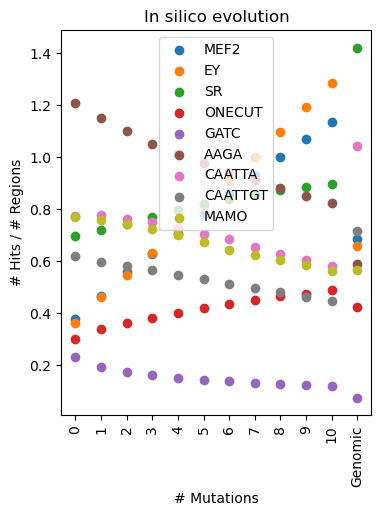

In [13]:
plt.figure(figsize=(4,5))
for i, [metacluster_name, pattern_name, TF_name] in enumerate([[0,0,"MEF2"],[0,1,"EY"],[0,2,"SR"],[0,9,"ONECUT"],[1,0,"GATC"],[1,1,"AAGA"],[1,2,"CAATTA"],[1,4,"CAATTGT"],[1,6,"MAMO"]]):
    data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==metacluster_name,EFS_cbust_mot_array_merged[0][:,2]==pattern_name))]
    th_ = np.mean(data_)+1*np.std(data_)
    print(f'{TF_name} threshold: {th_}')
    ratios = []
    for n_mut in range(11):
        data_ = np.sum(EFS_cbust_mot_array_merged[n_mut][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[n_mut][:,1]==metacluster_name,EFS_cbust_mot_array_merged[n_mut][:,2]==pattern_name))]>th_)
        ratios.append(data_/6000)
        plt.scatter(n_mut,data_/6000,color=f'C{i}')
    data_ = np.sum(Genomic_cbust_mot_array_merged['score'][(Genomic_cbust_mot_array_merged['metacluster_name'] == metacluster_name) & (Genomic_cbust_mot_array_merged['pattern_name'] == pattern_name)]>th_)
    plt.scatter(11,data_/6126,color=f'C{i}',label=TF_name)
    ratios.append(data_/6126)
    #_ = plt.ylim(bottom=0)
plt.ylabel("# Hits / # Regions")
plt.xlabel("# Mutations")
plt.title("In silico evolution")
plt.legend()
_ = plt.xticks(range(12),list(range(11))+["Genomic"],rotation=90)
plt.savefig("figures/cbust/EFS_motif.pdf",transparent=True)

### Plotting the motif enrichment results at different iterations of GAN

MEF2 threshold: 5.56909504454266
EY threshold: 5.759107705628423
SR threshold: 4.926998617890904
ONECUT threshold: 5.843680302821495
GATC threshold: 6.197624133034149
AAGA threshold: 4.936397485147413
CAATTA threshold: 5.207287520378128
CAATTGT threshold: 5.588375850236185
MAMO threshold: 5.5379978697806855


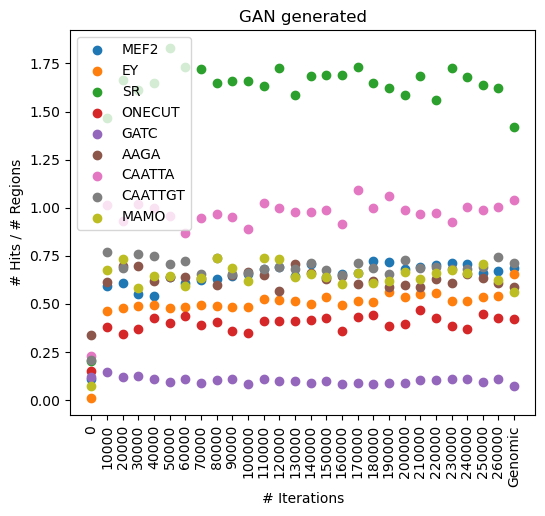

In [14]:
plt.figure(figsize=(6,5))
for i, [metacluster_name, pattern_name, TF_name] in enumerate([[0,0,"MEF2"],[0,1,"EY"],[0,2,"SR"],[0,9,"ONECUT"],[1,0,"GATC"],[1,1,"AAGA"],[1,2,"CAATTA"],[1,4,"CAATTGT"],[1,6,"MAMO"]]):
    data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==metacluster_name,EFS_cbust_mot_array_merged[0][:,2]==pattern_name))]
    th_ = np.mean(data_)+1*np.std(data_)
    print(f'{TF_name} threshold: {th_}')
    ratios = []
    for n_mut in GAN_cbust_mot_array_merged:
        data_ = np.sum(GAN_cbust_mot_array_merged[n_mut][:,5][np.logical_and.reduce((GAN_cbust_mot_array_merged[n_mut][:,1]==metacluster_name,GAN_cbust_mot_array_merged[n_mut][:,2]==pattern_name))]>th_)
        ratios.append(data_/6000)
        plt.scatter(n_mut,data_/6000,color=f'C{i}')
    data_ = np.sum(Genomic_cbust_mot_array_merged['score'][(Genomic_cbust_mot_array_merged['metacluster_name'] == metacluster_name) & (Genomic_cbust_mot_array_merged['pattern_name'] == pattern_name)]>th_)
    plt.scatter(270000,data_/6144,color=f'C{i}',label=TF_name)
    ratios.append(data_/6144)
    #_ = plt.ylim(bottom=0)
plt.ylabel("# Hits / # Regions")
plt.xlabel("# Iterations")
plt.legend()
plt.title("GAN generated")
_ = plt.xticks(range(0,280000,10000),list(range(0,270000,10000))+["Genomic"],rotation=90)
plt.savefig("figures/cbust/GAN_motif.pdf",transparent=True)

### Plotting the motif enrichment results at different orders used to generate background sequences

MEF2 threshold: 5.56909504454266
EY threshold: 5.759107705628423
SR threshold: 4.926998617890904
ONECUT threshold: 5.843680302821495
GATC threshold: 6.197624133034149
AAGA threshold: 4.936397485147413
CAATTA threshold: 5.207287520378128
CAATTGT threshold: 5.588375850236185
MAMO threshold: 5.5379978697806855


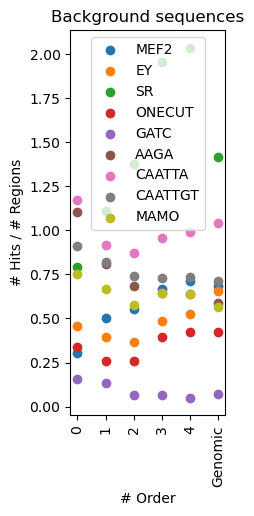

In [15]:
plt.figure(figsize=(2,5))
for i, [metacluster_name, pattern_name, TF_name] in enumerate([[0,0,"MEF2"],[0,1,"EY"],[0,2,"SR"],[0,9,"ONECUT"],[1,0,"GATC"],[1,1,"AAGA"],[1,2,"CAATTA"],[1,4,"CAATTGT"],[1,6,"MAMO"]]):
    data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==metacluster_name,EFS_cbust_mot_array_merged[0][:,2]==pattern_name))]
    th_ = np.mean(data_)+1*np.std(data_)
    print(f'{TF_name} threshold: {th_}')
    ratios = []
    for n_mut in BG_cbust_mot_array_merged:
        data_ = np.sum(BG_cbust_mot_array_merged[n_mut][:,5][np.logical_and.reduce((BG_cbust_mot_array_merged[n_mut][:,1]==metacluster_name,BG_cbust_mot_array_merged[n_mut][:,2]==pattern_name))]>th_)
        ratios.append(data_/6000)
        plt.scatter(n_mut,data_/6000,color=f'C{i}')
    data_ = np.sum(Genomic_cbust_mot_array_merged['score'][(Genomic_cbust_mot_array_merged['metacluster_name'] == metacluster_name) & (Genomic_cbust_mot_array_merged['pattern_name'] == pattern_name)]>th_)
    plt.scatter(5,data_/6144,color=f'C{i}',label=TF_name)
    ratios.append(data_/6144)
    #_ = plt.ylim(bottom=0)
plt.ylabel("# Hits / # Regions")
plt.xlabel("# Order")
plt.title("Background sequences")
plt.legend()
_ = plt.xticks(range(6),list(range(5))+["Genomic"],rotation=90)
plt.savefig("figures/cbust/BG_motif.pdf",transparent=True)

### Plotting the delta motif enrichment results at different mutational steps

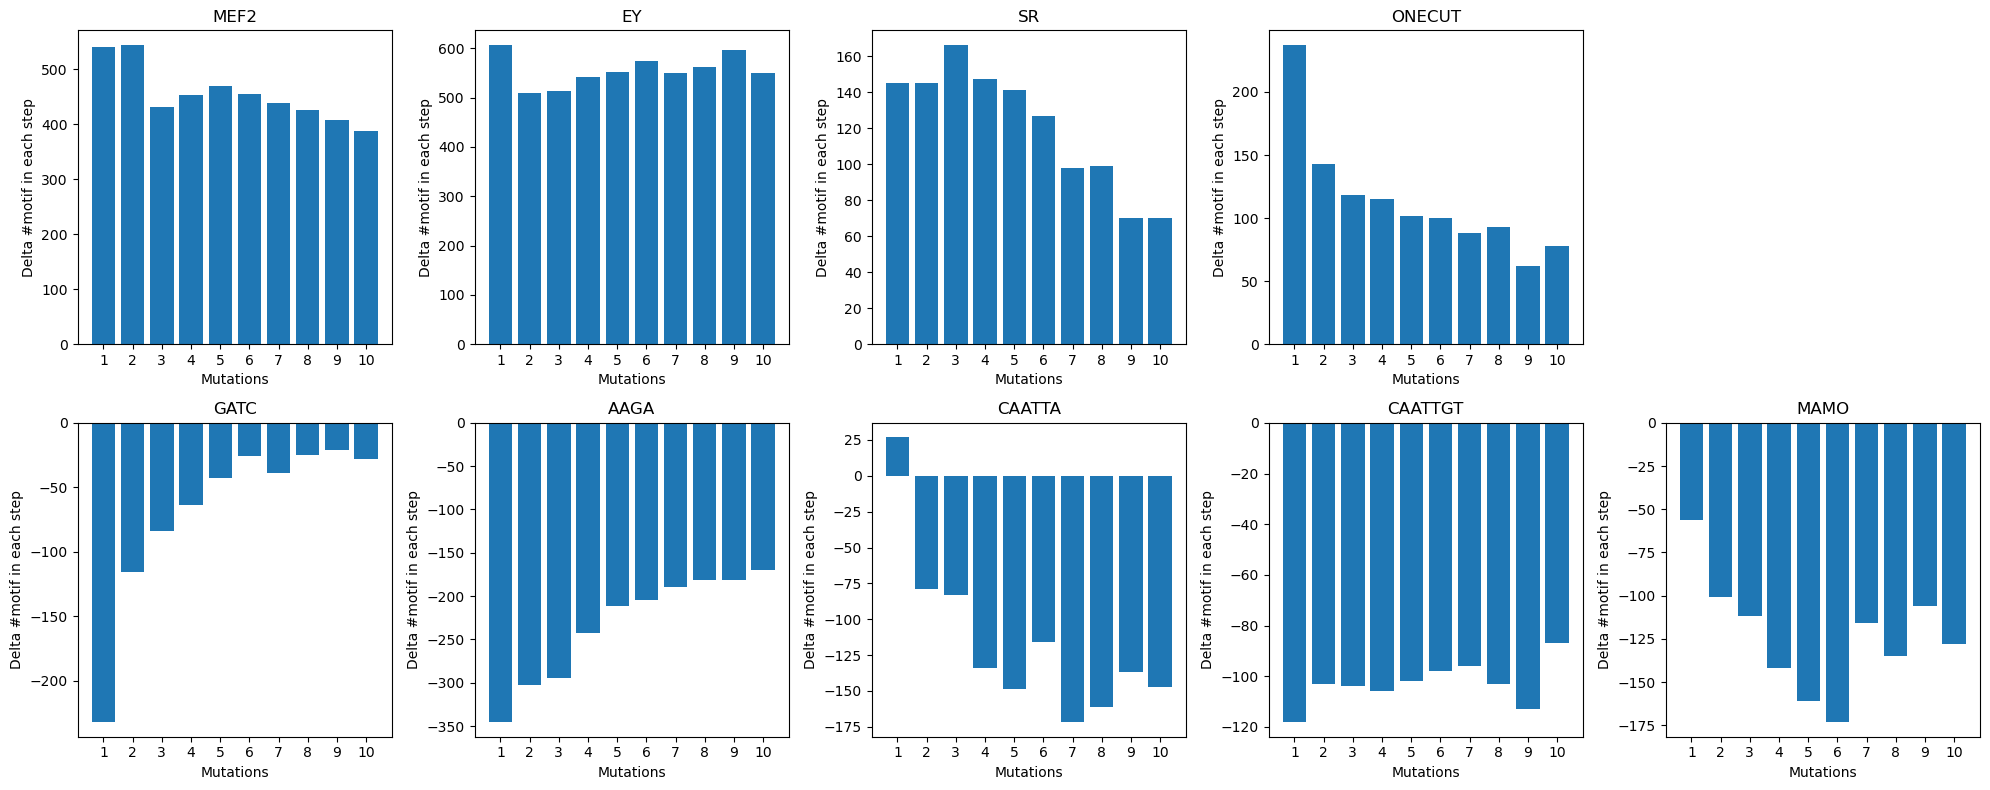

In [16]:
fig = plt.figure(figsize=(20,8))
for i, [metacluster_name, pattern_name, TF_name] in enumerate([[0,0,"MEF2"],[0,1,"EY"],[0,2,"SR"],[0,9,"ONECUT"],[1,0,"GATC"],[1,1,"AAGA"],[1,2,"CAATTA"],[1,4,"CAATTGT"],[1,6,"MAMO"]]):
    if i >= 4:
        i=i+1
    ax = fig.add_subplot(2,5,i+1)
    x = []
    for n_mut in range(11):
        data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==metacluster_name,EFS_cbust_mot_array_merged[0][:,2]==pattern_name))]
        th_ = np.mean(data_)+1*np.std(data_)
        cbust_mot_data = pd.DataFrame(EFS_cbust_mot_array_merged[n_mut], columns = ["seq_name", "metacluster_name", "pattern_name", "start", "end", "score", ])#"strand"])
        x.append(len(cbust_mot_data[(cbust_mot_data['metacluster_name'] == metacluster_name) & 
                                             (cbust_mot_data['pattern_name'] == pattern_name) & 
                                             (cbust_mot_data['score'] >= th_)]))

    plt.bar(range(10),np.diff(x))
    plt.title(TF_name)
    plt.xlabel("Mutations")
    plt.ylabel("Delta #motif in each step")
    plt.xticks(range(10),list(range(1,11)))
fig.tight_layout()
plt.savefig("figures/cbust/EFS_delta_motif.pdf",transparent=True)

### Selecting the sequences to be tested

In [17]:
n_mut = 10
cbust_mot_data = pd.DataFrame(EFS_cbust_mot_array_merged[n_mut], columns = ["seq_name", "metacluster_name", "pattern_name", "start", "end", "score"])

data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==0,EFS_cbust_mot_array_merged[0][:,2]==1))]
th_ = np.mean(data_)+1*np.std(data_)
EY_set = set(cbust_mot_data['seq_name'][ (cbust_mot_data['metacluster_name']==0) & (cbust_mot_data['pattern_name']==1) & (cbust_mot_data['score']>th_)])

data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==0,EFS_cbust_mot_array_merged[0][:,2]==0))]
th_ = np.mean(data_)+1*np.std(data_)
MEF2_set = set(cbust_mot_data['seq_name'][ (cbust_mot_data['metacluster_name']==0) & (cbust_mot_data['pattern_name']==0) & (cbust_mot_data['score']>th_)])

np.sort(list(set(EY_set) & set(MEF2_set)))[:80]

array([  0.,   1.,   2.,   4.,   5.,   6.,   7.,  15.,  16.,  18.,  19.,
        20.,  21.,  22.,  23.,  27.,  28.,  32.,  33.,  35.,  36.,  38.,
        41.,  44.,  45.,  46.,  47.,  50.,  52.,  54.,  55.,  56.,  57.,
        59.,  61.,  63.,  65.,  67.,  68.,  69.,  73.,  77.,  78.,  80.,
        82.,  86.,  88.,  89.,  91.,  93.,  95.,  96.,  98.,  99., 102.,
       105., 108., 111., 113., 115., 116., 117., 119., 120., 122., 125.,
       126., 128., 129., 130., 135., 137., 139., 143., 145., 146., 148.,
       151., 152., 153.])

In [18]:
print("Selected IDs:",*[1,21,32,35,59,61,91,102,117,120,126,135,148])

Selected IDs: 1 21 32 35 59 61 91 102 117 120 126 135 148


### Printing the number of motif hits at different mutational steps

In [19]:
import pandas as pd
for i,seq_id in enumerate([1,21,32,35,59,61,91,102,117,120,126,135,148]):
    print("------")
    for k, [metacluster_name, pattern_name, TF_name] in enumerate([[0,0,"MEF2"],[0,1,"EY"],[0,2,"SR"],[0,9,"ONECUT"],[1,0,"GATC"],[1,1,"AAGA"],[1,2,"CAATTA"],[1,4,"CAATTGT"],[1,6,"MAMO"]]):
        data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==metacluster_name,EFS_cbust_mot_array_merged[0][:,2]==pattern_name))]
        th_ = np.mean(data_)+1*np.std(data_)

        print(f'EFS-{i+1}_mut10_{TF_name}')
        n_mut = 10
        cbust_mot_data = pd.DataFrame(EFS_cbust_mot_array_merged[n_mut], columns = ["seq_name", "metacluster_name", "pattern_name", "start", "end", "score"])
        print(cbust_mot_data[(cbust_mot_data['seq_name']==seq_id) & (cbust_mot_data['metacluster_name']==metacluster_name) & (cbust_mot_data['pattern_name']==pattern_name) & (cbust_mot_data['score']>th_)])


------
EFS-1_mut10_MEF2
   seq_name  metacluster_name  pattern_name  start    end  score
7       1.0               0.0           0.0  137.0  149.0   10.2
EFS-1_mut10_EY
       seq_name  metacluster_name  pattern_name  start   end  score
17314       1.0               0.0           1.0   71.0  88.0   11.0
EFS-1_mut10_SR
       seq_name  metacluster_name  pattern_name  start    end  score
78062       1.0               0.0           2.0  463.0  475.0   5.53
EFS-1_mut10_ONECUT
Empty DataFrame
Columns: [seq_name, metacluster_name, pattern_name, start, end, score]
Index: []
EFS-1_mut10_GATC
Empty DataFrame
Columns: [seq_name, metacluster_name, pattern_name, start, end, score]
Index: []
EFS-1_mut10_AAGA
        seq_name  metacluster_name  pattern_name  start    end  score
270903       1.0               1.0           1.0  406.0  414.0   5.56
270906       1.0               1.0           1.0  454.0  462.0   6.51
EFS-1_mut10_CAATTA
        seq_name  metacluster_name  pattern_name  start    end  sc

In [7]:
import pandas as pd
for i,seq_id in enumerate([35]):
    print("------")
    for k, [metacluster_name, pattern_name, TF_name] in enumerate([[0,0,"MEF2"],[0,1,"EY"],[0,2,"SR"],[0,9,"ONECUT"],[1,0,"GATC"],[1,1,"AAGA"],[1,2,"CAATTA"],[1,4,"CAATTGT"],[1,6,"MAMO"]]):
        data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==metacluster_name,EFS_cbust_mot_array_merged[0][:,2]==pattern_name))]
        th_ = 0#np.mean(data_)#+1*np.std(data_)

        print(f'EFS-{i+1}_mut10_{TF_name}')
        n_mut = 10
        cbust_mot_data = pd.DataFrame(EFS_cbust_mot_array_merged[n_mut], columns = ["seq_name", "metacluster_name", "pattern_name", "start", "end", "score"])
        print(cbust_mot_data[(cbust_mot_data['seq_name']==seq_id) & (cbust_mot_data['metacluster_name']==metacluster_name) & (cbust_mot_data['pattern_name']==pattern_name) & (cbust_mot_data['score']>th_)])


------
EFS-1_mut10_MEF2
      seq_name  metacluster_name  pattern_name  start    end  score
7954      35.0               0.0           0.0  107.0  119.0   4.37
7955      35.0               0.0           0.0  241.0  253.0   4.38
7956      35.0               0.0           0.0  329.0  341.0  10.70
7957      35.0               0.0           0.0  479.0  491.0   3.47
EFS-1_mut10_EY
       seq_name  metacluster_name  pattern_name  start    end  score
26144      35.0               0.0           1.0  219.0  236.0  10.40
26145      35.0               0.0           1.0  382.0  399.0   4.43
EFS-1_mut10_SR
       seq_name  metacluster_name  pattern_name  start    end  score
91725      35.0               0.0           2.0   60.0   70.0   3.15
91726      35.0               0.0           2.0   87.0  101.0   4.11
91727      35.0               0.0           2.0  156.0  166.0   5.11
91728      35.0               0.0           2.0  309.0  319.0   3.76
91729      35.0               0.0           2.0  392.0

In [3]:
import pandas as pd
for i,seq_id in enumerate([1,21,32,35,59,61,91,102,117,120,126,135,148]):
    print("------")
    for k, [metacluster_name, pattern_name, TF_name] in enumerate([[0,0,"MEF2"],[0,1,"EY"],[0,2,"SR"],[0,9,"ONECUT"],[1,0,"GATC"],[1,1,"AAGA"],[1,2,"CAATTA"],[1,4,"CAATTGT"],[1,6,"MAMO"]]):
        data_ = EFS_cbust_mot_array_merged[0][:,5][np.logical_and.reduce((EFS_cbust_mot_array_merged[0][:,1]==metacluster_name,EFS_cbust_mot_array_merged[0][:,2]==pattern_name))]
        th_ = np.mean(data_)+1*np.std(data_)

        print(f'EFS-{i+1}_mut10_{TF_name}')
        n_mut = 10
        cbust_mot_data = pd.DataFrame(EFS_cbust_mot_array_merged[n_mut], columns = ["seq_name", "metacluster_name", "pattern_name", "start", "end", "score"])
        print(cbust_mot_data[(cbust_mot_data['seq_name']==seq_id) & (cbust_mot_data['metacluster_name']==metacluster_name) & (cbust_mot_data['pattern_name']==pattern_name) & (cbust_mot_data['score']>th_)])


------
EFS-1_mut10_MEF2
   seq_name  metacluster_name  pattern_name  start    end  score
7       1.0               0.0           0.0  137.0  149.0   10.2
EFS-1_mut10_EY
       seq_name  metacluster_name  pattern_name  start   end  score
17314       1.0               0.0           1.0   71.0  88.0   11.0
EFS-1_mut10_SR
       seq_name  metacluster_name  pattern_name  start    end  score
78062       1.0               0.0           2.0  463.0  475.0   5.53
EFS-1_mut10_ONECUT
Empty DataFrame
Columns: [seq_name, metacluster_name, pattern_name, start, end, score]
Index: []
EFS-1_mut10_GATC
Empty DataFrame
Columns: [seq_name, metacluster_name, pattern_name, start, end, score]
Index: []
EFS-1_mut10_AAGA
        seq_name  metacluster_name  pattern_name  start    end  score
270903       1.0               1.0           1.0  406.0  414.0   5.56
270906       1.0               1.0           1.0  454.0  462.0   6.51
EFS-1_mut10_CAATTA
        seq_name  metacluster_name  pattern_name  start    end  sc

In [20]:
#random 6000
#genomic 6126
#gan 6144

### Running Homer using Random and Evolved sequences as foreground and background sequences, and vice versa

In [21]:
# %%bash

# module load HOMER/4.10.4-foss-2018a

# cd data/homer/M10_vs_M0
# target_fasta=data/cbust/EFS_fasta/KCEFS_M10.fa
# background_fasta=data/cbust/EFS_fasta/KCEFS_M0.fa
# findMotifs.pl ${target_fasta} fasta ./ -fasta ${background_fasta}

# cd data/homer/M0_vs_M10
# background_fasta=data/cbust/EFS_fasta/KCEFS_M10.fa
# target_fasta=data/cbust/EFS_fasta/KCEFS_M0.fa
# findMotifs.pl ${target_fasta} fasta ./ -fasta ${background_fasta}